## VIT GPT-2 Transformers Notebook

In this notebook, we will import the pre-trained VIT GPT-2 Image Caption Generator and test it with the same test set as the LSTM-based model.

In [1]:
GLOVE_LOAD_FROM_PICKLE = True

### Setting up the Environment

Installing Relevent Modules

In [2]:
! pip install great_expectations ipywidgets rich seaborn torch datasets transformers tokenizers sentencepiece sacremoses rouge-score --quiet

     |████████████████████████████████| 5.2 MB 40.5 MB/s 
     |████████████████████████████████| 237 kB 54.9 MB/s 
     |████████████████████████████████| 451 kB 79.7 MB/s 
     |████████████████████████████████| 5.8 MB 64.0 MB/s 
     |████████████████████████████████| 7.6 MB 67.5 MB/s 
     |████████████████████████████████| 1.3 MB 77.0 MB/s 
     |████████████████████████████████| 880 kB 92.5 MB/s 
     |████████████████████████████████| 4.0 MB 77.6 MB/s 
     |████████████████████████████████| 109 kB 96.9 MB/s 
     |████████████████████████████████| 439 kB 94.7 MB/s 
     |████████████████████████████████| 140 kB 96.8 MB/s 
     |████████████████████████████████| 761 kB 94.0 MB/s 
     |████████████████████████████████| 386 kB 88.4 MB/s 
     |████████████████████████████████| 1.6 MB 85.8 MB/s 
     |████████████████████████████████| 9.8 MB 86.4 MB/s 
     |████████████████████████████████| 423 kB 95.5 MB/s 
     |████████████████████████████████| 360 kB 98.4 MB/s 
     |████████

Importing relevant modules

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rich
import random
from functools import partial
import pickle
import great_expectations as ge
import time

import glob
import os
from tqdm.notebook import tqdm
from collections import Counter
from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
import skimage

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary            
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn

from PIL import Image 

import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.chrf_score import corpus_chrf
from rouge_score import rouge_scorer

import gc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
gc.collect()

0

Setting up Device

In [5]:
cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cuda

Constants

In [6]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.70 # 0.70
VAL_SIZE = 0.15 # 0.15
TEST_SIZE = 0.15
IMAGE_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 8
NUM_CAPTIONS_PER_IMAGE = 5

Setting up Google Drive for development on Colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
drive_path = 'drive/My Drive/'

### Loading the data

We first start by loading the data, where we consolidate the image file names present in the data set. We also load the captions file, which contains the 5 captions tagged to their respective images.

In [9]:
image_paths = glob.glob(f'{drive_path}data/flickr_8k_dataset/Images/*.jpg')
print("Total Images:\t", len(image_paths))

captions = pd.read_csv(f'{drive_path}data/flickr_8k_dataset/captions.txt')
images = [f'{drive_path}data/flickr_8k_dataset/Images/{i}' for i in captions.image.values]

print(images[:3])
captions.head()

Total Images:	 8091
['drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg']


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
captions['caption'].apply(lambda x: len(x)).sort_values()

9305       1
33360      1
23226      7
34525      9
11363      9
        ... 
2596     162
16688    167
13244    170
2730     173
8049     199
Name: caption, Length: 40455, dtype: int64

### Data Sanity Check

Next, we perform preliminary data sanity checks to ensure the cleanliness and validity of the data. We will make use of the great_expectations (GE) package to assist in these checks.

In summary, we will perform the following checks:

1. No null values
2. Caption data are of appropriate types
3. No images listed in the captions file that are missing in the images folder, vice versa
4. Each image contains exactly 5 accompanying captions

In [ ]:
def check_expectations(df, column, expectation):
  ge_df = ge.from_pandas(df)
  ge_result = ge_df.expect_column_values_to_be_in_set(column, expectation)

  return {
    "Outcome: ": ge_result["success"],
    "Results: ": ge_result["result"]
    }

In [ ]:
check_expectations(captions, "image", [i.split("/")[-1] for i in image_paths]) # check if all image names in the captions df are present in the image_paths

{'Outcome: ': True,
 'Results: ': {'element_count': 40455,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [ ]:
caption_counts = captions.groupby("image").count()

check_expectations(caption_counts, "caption", [5]) # check that all images have 5 accompanying captions

{'Outcome: ': True,
 'Results: ': {'element_count': 8091,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [ ]:
assert(set(captions["image"]) == set([i.split("/")[-1] for i in image_paths]))

Data passes sanity checks. There are no null and missing values, and the columns contain the expected image files names and the number of accomanying captions per image.

### Visualising the Data

First, we would like to visualise a few sample images.

In [ ]:
def get_sample_image(image_paths, n):
  sample_images_path = random.sample(image_paths,n)
  sample_images_name = [i.split('/')[-1] for i in sample_images_path] 
  return sample_images_path, sample_images_name

def show_image(image_path):
  image = imread(image_path)
  plt.imshow(image)
  plt.axis('off')

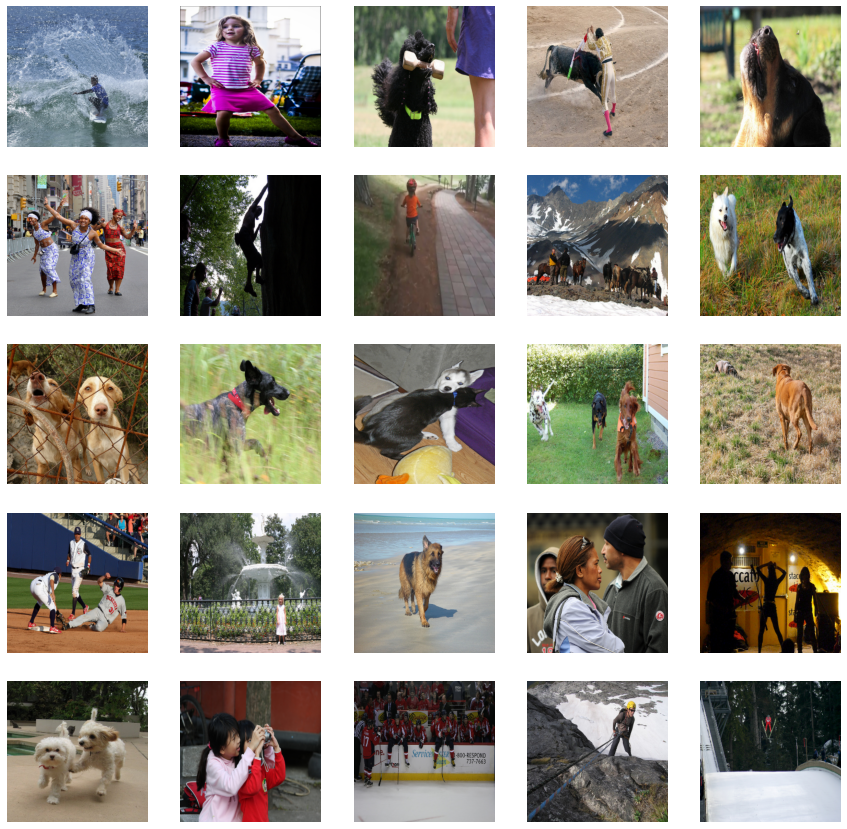

In [ ]:
n_samples = 5*5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

fig = plt.figure(figsize=(15, 15))

columns = 5
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  image = skimage.img_as_ubyte(resize(image, (IMAGE_SIZE,IMAGE_SIZE)))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

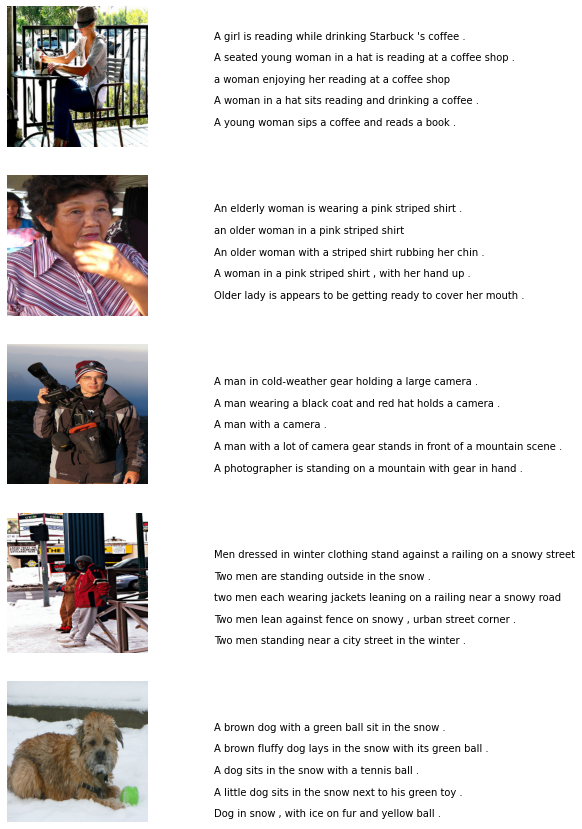

In [ ]:
n_samples = 5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

sample_images_captions = {i:captions[captions["image"] == i]["caption"].values for i in sample_images_name}

fig = plt.figure(figsize=(8, 15))

columns = 1
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  image = resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  for enum, caption in enumerate(sample_images_captions[sample_images_name[i]]):
    plt.figtext(0.75,0.85+i*-0.16-0.02*enum, caption)

### Caption and Image Data Preparation

Due to the sequence generation nature of the model, we need to input special words indicating START, END, UKNOWN, PAD, to indicate when the sequence starts, ends, is an unseen word, or is a padding token respectively.

In [ ]:
start_token = "<|start|>"
end_token = "<|end|>"
unknown_token = "<|unk|>"
pad_token = "<|pad|>"

special_tokens = [pad_token, start_token, end_token, unknown_token]

In [ ]:
# Removing full stops at the end

def remove_full_stop(caption):
  if caption[-1] == '.':
    caption = caption[:-1]
  return caption

captions['caption'] = captions['caption'].apply(remove_full_stop) 

In [ ]:
max_caption_length = max(captions["caption"].apply(lambda x: len(x.split())))

def add_special_tokens(caption):
  n_pads = max_caption_length - len(caption.split())
  updated_caption = start_token + " " + caption + " " + end_token + n_pads * (" " + pad_token)
  return updated_caption

In [ ]:
captions['caption_pad'] = captions['caption'].apply(lambda x: add_special_tokens(x))
captions['caption_pad']

0        <|start|> A child in a pink dress is climbing ...
1        <|start|> A girl going into a wooden building ...
2        <|start|> A little girl climbing into a wooden...
3        <|start|> A little girl climbing the stairs to...
4        <|start|> A little girl in a pink dress going ...
                               ...                        
40450    <|start|> A man in a pink shirt climbs a rock ...
40451    <|start|> A man is rock climbing high in the a...
40452    <|start|> A person in a red shirt climbing up ...
40453    <|start|> A rock climber in a red shirt  <|end...
40454    <|start|> A rock climber practices on a rock c...
Name: caption_pad, Length: 40455, dtype: object

In [ ]:
captions['caption_pad'][0]

'<|start|> A child in a pink dress is climbing up a set of stairs in an entry way  <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>'

In [ ]:
set(captions['caption_pad'].apply(lambda x: len(x.split())))

{39}

#### Loading GloVe Pretrained Embeddings

In [ ]:
# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

In [ ]:
if not GLOVE_LOAD_FROM_PICKLE:
  # prepare data for the later cells
  glove_vocabulary, glove_vectors = load_glove_vectors()
  rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
  rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

  # add special tokens
  special_tokens = [pad_token, start_token, end_token, unknown_token]
  glove_vocabulary = special_tokens + glove_vocabulary
  glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

  # tokenizer for GloVe
  glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token=unknown_token))
  glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
  glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.WhitespaceSplit()

  # glove_tokenizer
  with open(f'{drive_path}data/flickr_8k_dataset/tokenizer.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_tokenizer, f)
      print("SUCCESS: GLOVE tokeniser pickled successfully")

  # glove_vocab
  with open(f'{drive_path}data/flickr_8k_dataset/vocab.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_vocabulary, f)
      print("SUCCESS: GLOVE vocabulary pickled successfully")

  # glove vectors
  with open(f'{drive_path}data/flickr_8k_dataset/vectors.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_vectors, f)
      print("SUCCESS: GLOVE vectors pickled successfully")

else:
  with open(f'{drive_path}data/flickr_8k_dataset/tokenizer.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_tokenizer = pickle.load(f)
    print("SUCCESS: GLOVE tokeniser loaded successfully")

  with open(f'{drive_path}data/flickr_8k_dataset/vocab.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_vocabulary = pickle.load(f)
    print("SUCCESS: GLOVE vocabulary loaded successfully")

  with open(f'{drive_path}data/flickr_8k_dataset/vectors.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_vectors = pickle.load(f)
    print("SUCCESS: GLOVE vectors loaded successfully")


SUCCESS: GLOVE tokeniser loaded successfully
SUCCESS: GLOVE vocabulary loaded successfully
SUCCESS: GLOVE vectors loaded successfully


In [ ]:
emb_dim = glove_vectors.size(1)

In [ ]:
# Encode the captions

captions['caption_ids'] = captions['caption_pad'].apply(lambda x: glove_tokenizer.encode(x).ids)

In [ ]:
captions['caption_ids']

0        [1, 11, 968, 10, 11, 5495, 4639, 18, 6856, 64,...
1        [1, 11, 1753, 226, 79, 11, 4840, 451, 2, 0, 0,...
2        [1, 11, 337, 1753, 6856, 79, 11, 4840, 19623, ...
3        [1, 11, 337, 1753, 6856, 4, 12322, 8, 75, 1962...
4        [1, 11, 337, 1753, 10, 11, 5495, 4639, 226, 79...
                               ...                        
40450    [1, 11, 304, 10, 11, 5495, 5102, 15655, 11, 11...
40451    [1, 11, 304, 18, 1141, 6856, 156, 10, 4, 329, ...
40452    [1, 11, 903, 10, 11, 643, 5102, 6856, 64, 11, ...
40453    [1, 11, 1141, 20930, 10, 11, 643, 5102, 2, 0, ...
40454    [1, 11, 1141, 20930, 3253, 17, 11, 1141, 6856,...
Name: caption_ids, Length: 40455, dtype: object

Next, we split the images into train, validation and test data. The same image should not be present in the training, validation and test data sets. To ensure this, we will split the training and test sets by unique image names.

In [ ]:
unique_image_names = list(set(captions["image"].values))

random.seed(RANDOM_STATE)

train_image_names = random.sample(unique_image_names, int(len(unique_image_names)*TRAIN_SIZE))
val_test_image_names = [image for image in unique_image_names if image not in train_image_names]
val_image_names = random.sample(val_test_image_names, int(len(unique_image_names)*VAL_SIZE))
test_image_names = [image for image in val_test_image_names if image not in val_image_names]


train_captions = captions[captions['image'].isin(train_image_names)].reset_index(drop=True)
val_captions = captions[captions['image'].isin(val_image_names)].reset_index(drop=True)
test_captions = captions[captions['image'].isin(test_image_names)].reset_index(drop=True)

print(f"Train Images: {len(train_image_names)}")
print(f"Validation Images: {len(val_image_names)}")
print(f"Test Images: {len(test_image_names)}")

print(f"Train Captions: {train_captions.shape[0]}")
print(f"Validation Captions: {val_captions.shape[0]}")
print(f"Test Captions: {test_captions.shape[0]}")

Train Images: 5663
Validation Images: 1213
Test Images: 1215
Train Captions: 28315
Validation Captions: 6065
Test Captions: 6075


In [ ]:
train_captions["caption"].apply(lambda x: len(x.split()))

0        17
1         7
2         8
3         9
4        12
         ..
28310    10
28311     9
28312    15
28313     7
28314     9
Name: caption, Length: 28315, dtype: int64

In [ ]:
captions

,image,caption,caption_pad,caption_ids
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<|start|> A child in a pink dress is climbing ...,"[1, 11, 968, 10, 11, 5495, 4639, 18, 6856, 64,..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building,<|start|> A girl going into a wooden building ...,"[1, 11, 1753, 226, 79, 11, 4840, 451, 2, 0, 0,..."
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse,<|start|> A little girl climbing into a wooden...,"[1, 11, 337, 1753, 6856, 79, 11, 4840, 19623, ..."
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<|start|> A little girl climbing the stairs to...,"[1, 11, 337, 1753, 6856, 4, 12322, 8, 75, 1962..."
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<|start|> A little girl in a pink dress going ...,"[1, 11, 337, 1753, 10, 11, 5495, 4639, 226, 79..."
...,...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,<|start|> A man in a pink shirt climbs a rock ...,"[1, 11, 304, 10, 11, 5495, 5102, 15655, 11, 11..."
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air,<|start|> A man is rock climbing high in the a...,"[1, 11, 304, 18, 1141, 6856, 156, 10, 4, 329, ..."
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,<|start|> A person in a red shirt climbing up ...,"[1, 11, 903, 10, 11, 643, 5102, 6856, 64, 11, ..."
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt,<|start|> A rock climber in a red shirt <|end...,"[1, 11, 1141, 20930, 10, 11, 643, 5102, 2, 0, ..."


Creating a custom dataloader class.

In [ ]:
class ImageCaptionDataset(Dataset):

  def __init__(self, drive_path, image_names, captions):
    self.drive_path = drive_path
    self.image_names = captions['image']
    self.caption_names = captions["caption"]
    self.captions_ids = captions["caption_ids"].values
    self.dataset_size = self.captions_ids.size

  def __getitem__(self, caption_number):
    image_number = caption_number 
    image_name = self.image_names[image_number]
    caption = self.caption_names[caption_number]

    return image_name, caption

  def __len__(self):
    return self.dataset_size

In [ ]:
train_captions

,image,caption,caption_pad,caption_ids
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<|start|> A child in a pink dress is climbing ...,"[1, 11, 968, 10, 11, 5495, 4639, 18, 6856, 64,..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building,<|start|> A girl going into a wooden building ...,"[1, 11, 1753, 226, 79, 11, 4840, 451, 2, 0, 0,..."
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse,<|start|> A little girl climbing into a wooden...,"[1, 11, 337, 1753, 6856, 79, 11, 4840, 19623, ..."
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<|start|> A little girl climbing the stairs to...,"[1, 11, 337, 1753, 6856, 4, 12322, 8, 75, 1962..."
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<|start|> A little girl in a pink dress going ...,"[1, 11, 337, 1753, 10, 11, 5495, 4639, 226, 79..."
...,...,...,...,...
28310,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,<|start|> A man in a pink shirt climbs a rock ...,"[1, 11, 304, 10, 11, 5495, 5102, 15655, 11, 11..."
28311,997722733_0cb5439472.jpg,A man is rock climbing high in the air,<|start|> A man is rock climbing high in the a...,"[1, 11, 304, 18, 1141, 6856, 156, 10, 4, 329, ..."
28312,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,<|start|> A person in a red shirt climbing up ...,"[1, 11, 903, 10, 11, 643, 5102, 6856, 64, 11, ..."
28313,997722733_0cb5439472.jpg,A rock climber in a red shirt,<|start|> A rock climber in a red shirt <|end...,"[1, 11, 1141, 20930, 10, 11, 643, 5102, 2, 0, ..."


In [ ]:
test_loader = torch.utils.data.DataLoader(
    ImageCaptionDataset(drive_path, test_image_names, test_captions),
    batch_size=1, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

## VIT GPT-2 Transformer

In this section, we will be testing a State-of-the-Art Transformer-based model, and comparing it with the LSTM-based model.

In [10]:
image_path = f'{drive_path}data/flickr_8k_dataset/sample/sample1.png'

In [11]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

In [12]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

model.to(DEVICE)

Downloading:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/982M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/120 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [14]:
max_length = 160
beam_size = 5
gen_kwargs = {"max_length": max_length, "num_beams": beam_size}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(DEVICE)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


predict_step([image_path]) 

['people walking down a sidewalk next to a row of bicycles']

## Model Testing

In this section, we test the GPT-2 based Transformer Model with the unseen test data of our dataset. We use the test loader as defined earlier. In the testing, we will utilise beam search to produce the best possible caption sequence for each image. 

In [ ]:
# Model testing

# Defining Beam Size
beam_size = 5
max_length = 16
gen_kwargs = {"max_length": max_length, "num_beams": beam_size}
captions_per_image = 5

def test(test_loader):
  
  # Containers to store inferences and reference captions
  references = []
  inferences = []

  _ref = []
  _infer = []

  # iterating through test captions
  for i, (image, caption) in enumerate(tqdm(test_loader)):

    # Get most probable caption using beam search
    images = []
    image_path = f'{drive_path}data/flickr_8k_dataset/Images/{image[0]}'
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")
    images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(DEVICE)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    complete_seqs = preds[0].split()


    # Populate References with truth captions. Filter away special tokens
    img_caps = caption[0]
    _ref.append([word.lower() for word in img_caps.split()])

    # Populate inferences with predicted captions. Filter away special tokens
    _infer.append([word.lower() for word in complete_seqs])


    if len(_ref) == captions_per_image and len(_infer) == captions_per_image:
      references.append(_ref)
      inferences.append(_infer[0])
      _ref = []
      _infer = []
  
  # print(references)
  # print(inferences)


  # Calculating BLEU scores
  bleu2_score = corpus_bleu(references, inferences,  weights = [(1./2. , 1./2.)])
  bleu3_score = corpus_bleu(references, inferences,  weights = [(1./3. , 1./3., 1./3.)])
  bleu4_score = corpus_bleu(references, inferences,  weights = [(1./4. , 1./4., 1./4., 1./4.)])

  return (bleu2_score, bleu3_score, bleu4_score)


In [ ]:
bleu_score_test = test(test_loader)

  0%|          | 0/6075 [00:00<?, ?it/s]

In [ ]:
test_scores = {
    "BLEU-2": bleu_score_test[0],
    "BLEU-3": bleu_score_test[1],
    "BLEU-4": bleu_score_test[2],
}

In [ ]:
pd.DataFrame(test_scores, index=['Score']).T

,Score
BLEU-2,0.301682
BLEU-3,0.158115
BLEU-4,0.085630
